In [1]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit
from qiskit.quantum_info import  Statevector, random_statevector, SparsePauliOp
from qiskit.visualization import plot_bloch_multivector
from qiskit_experiments.library.tomography import StateTomography
from qiskit.primitives import Estimator
from qiskit.providers.aer import AerSimulator
from qiskit.providers.aer.noise import NoiseModel, amplitude_damping_error
from qiskit.providers.fake_provider import FakeVigo

from exact_diagonalization import *

**Exercise 6**

**(a)**

In [2]:
def evolve_basic(circ, g, dt):
    for i in range(circ.num_qubits - 1):
        circ.rzz(-dt, i, i+1)
    for i in range(circ.num_qubits):
        circ.rx(-g*dt, i)
    return circ

**(b)**

In [3]:
def evolve_symmetric(circ, g, dt):
    for i in range(circ.num_qubits):
        circ.rx(-g*dt/2, i)
    for i in range(circ.num_qubits - 1):
        circ.rzz(-dt, i, i+1)
    for i in range(circ.num_qubits):
        circ.rx(-g*dt/2, i)
    return circ

**Exercise 7**

In [4]:
def simulate_magnetization(L, g, t, dt):

    estimator = Estimator()

    observable = SparsePauliOp.from_sparse_list([("Z", [i] ,1) for i in range(L)], num_qubits=L)

    circ_basic, circ_symm = QuantumCircuit(L), QuantumCircuit(L)
    ms_basic, ms_symm =  list(), list()
    for _ in range(round(t//dt)):
        evolve_basic(circ_basic, g, dt)

        m = estimator.run(circ_basic, observable).result().values / L
        ms_basic.append(m)

        evolve_symmetric(circ_symm, g, dt)

        m = estimator.run(circ_symm, observable).result().values / L
        ms_symm.append(m)

    return ms_basic, ms_symm

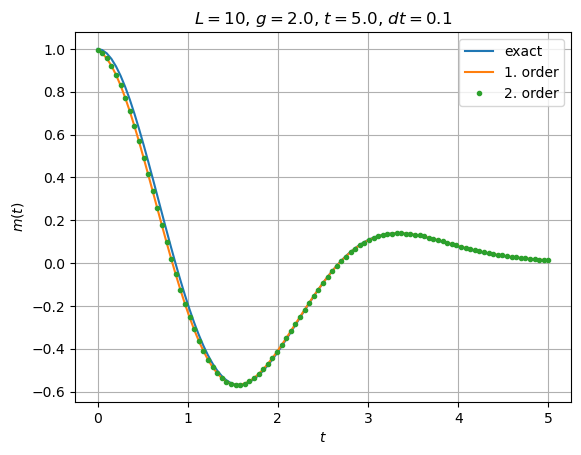

In [5]:
L, g, t, dt = 10, 2, 5, 0.05
ms_basic, ms_symm = simulate_magnetization(L, g, t, dt)
ms_exact = magn_exact_diagonalization(L, g, t, round(t//dt))


fig, ax = plt.subplots(1, 1)
ts = np.linspace(0, t, round(t//dt))
ax.plot(ts, ms_exact, '-', label='exact')
ax.plot(ts, ms_basic, '-', label='1. order')
ax.plot(ts, ms_symm, '.', label='2. order')
ax.set_title('$L=%d$, $g=%.1f$, $t=%.1f$, $dt=%.1f$'%(L, g, t, dt)), ax.set_xlabel("$t$"), ax.set_ylabel("$m(t)$"), ax.legend(), ax.grid();

**Exercise 8**

In [6]:
def simulate_rates(L, g, t, dt):

    steps = round(t//dt)
    circ = QuantumCircuit(L)

    λ0_list, λ1_list, λ_list =  list(), list(), list()
    for step in range(steps):

        evolve_basic(circ, g, dt)
        circ.save_statevector(label=str(step))

    sim = AerSimulator(method="statevector")
    result = sim.run(circ).result()

    for step in range(round(t//dt)):

        p = result.data()[str(step)].probabilities()
        p0, p1 = p[0], p[-1]
        λ0, λ1, λ = -np.log(p0)/L, -np.log(p1)/L, -np.log(p0 + p1)/L
        λ0_list.append(λ0), λ1_list.append(λ1), λ_list.append(λ)

    return λ0_list, λ1_list, λ_list

In [7]:
def simulate_rates_over_grid_and_plot(Ls, gs, t, dt):

    # simulate rates
    rates = {}
    for L in Ls:
        rates[L] = {}
        for g in gs:
            rates[L][g] = simulate_rates(L, g, t, dt)
            
    # plot results
    fig, axes = plt.subplots(3, 1, figsize=(12, 5))
    ts = np.linspace(0, t, round(t//dt))
    for k, ax in enumerate(axes):
        for L in Ls:
            for g in gs:
                ax.plot(ts, rates[L][g][k], '-', label='L=%d, g=%.2f'%(L, g))
        ax.set_ylabel("$\lambda(t)$" if k==2 else "$\lambda_{%d}(t)$"%(k)) 
        ax.grid()
    ax.set_xlabel("$t$")
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='center right')
    fig.subplots_adjust(wspace=1)
    fig.suptitle('$t=%.1f$, $dt=%.1f$'%(t, dt), fontsize="x-large")

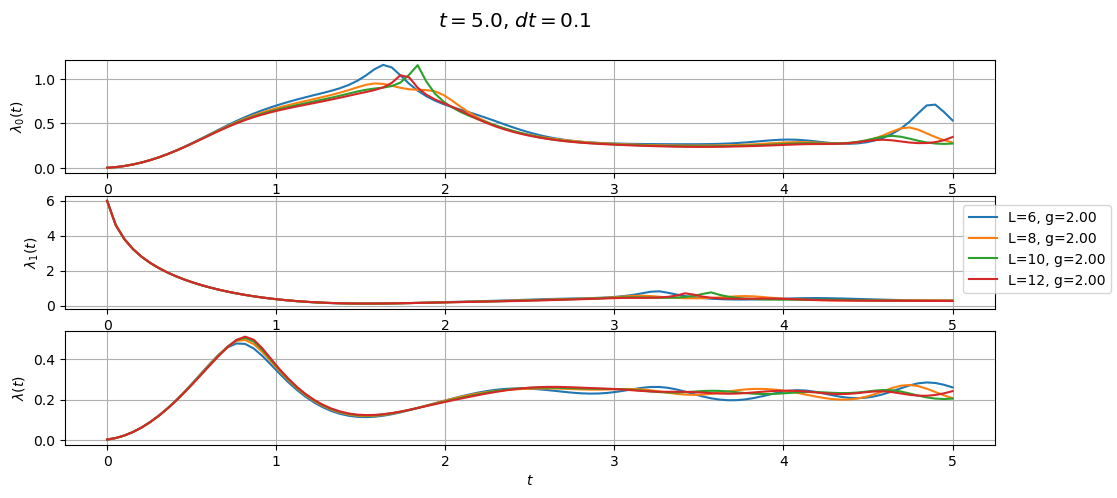

In [8]:
t, dt = 5, 0.05
Ls, gs = [6, 8, 10, 12], [2]

simulate_rates_over_grid_and_plot(Ls, gs, t, dt)

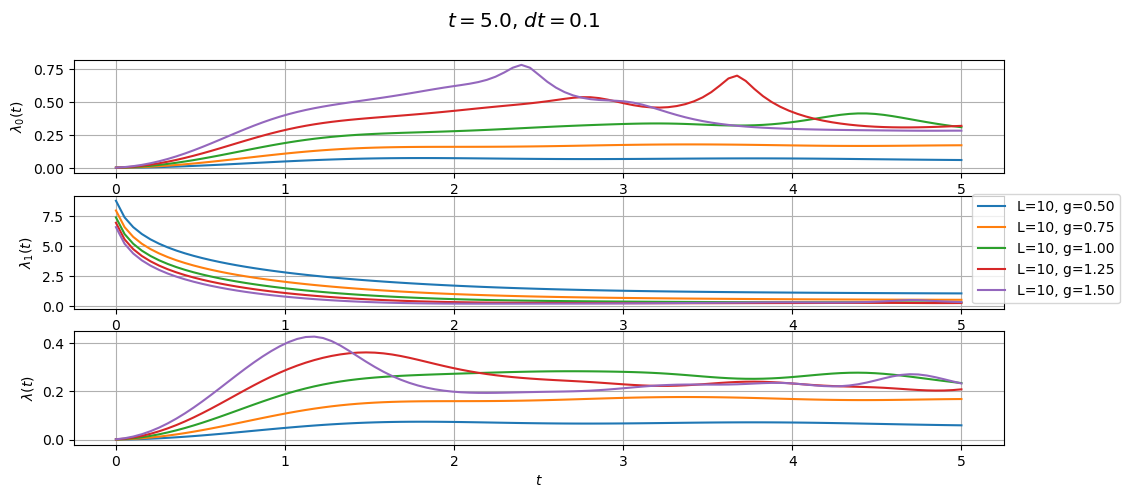

In [9]:
t, dt = 5, 0.05
Ls, gs = [10], [0.5, 0.75, 1.0, 1.25, 1.5]

simulate_rates_over_grid_and_plot(Ls, gs, t, dt)

**Exercise 9**

In [10]:
def measure_magnetization(L, g, t, dt, shots):

    estimator = Estimator()

    observable = SparsePauliOp.from_sparse_list([("Z", [i] ,1) for i in range(L)], num_qubits=L)

    circ_basic, circ_symm = QuantumCircuit(L), QuantumCircuit(L)
    ms_basic, ms_symm =  list(), list()
    for _ in range(round(t//dt)):
        evolve_basic(circ_basic, g, dt)

        m = estimator.run(circ_basic, observable, shots=shots).result().values / L
        ms_basic.append(m)

        evolve_symmetric(circ_symm, g, dt)

        m = estimator.run(circ_symm, observable, shots=shots).result().values / L
        ms_symm.append(m)

    return ms_basic, ms_symm

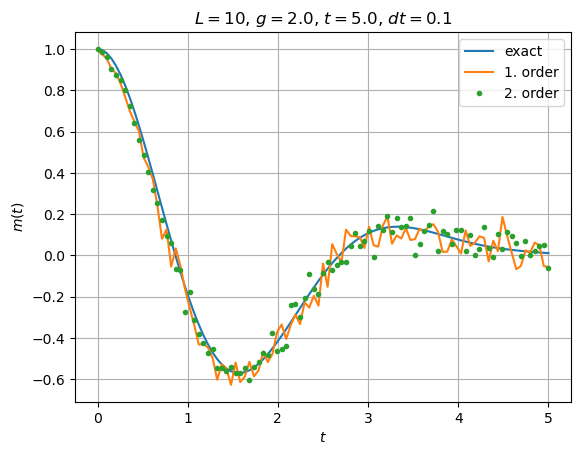

In [11]:
L, g, t, dt = 10, 2, 5, 0.05
ms_basic, ms_symm = measure_magnetization(L, g, t, dt, shots=100)
ms_exact = magn_exact_diagonalization(L, g, t, round(t//dt))


fig, ax = plt.subplots(1, 1)
ts = np.linspace(0, t, round(t//dt))
ax.plot(ts, ms_exact, '-', label='exact')
ax.plot(ts, ms_basic, '-', label='1. order')
ax.plot(ts, ms_symm, '.', label='2. order')
ax.set_title('$L=%d$, $g=%.1f$, $t=%.1f$, $dt=%.1f$'%(L, g, t, dt)), ax.set_xlabel("$t$"), ax.set_ylabel("$m(t)$"), ax.legend(), ax.grid();

In [12]:
def measure_rates(L, g, t, dt, shots):

    steps = round(t//dt)
    circ = QuantumCircuit(L)

    echos, λs = list(), list()
    for step in range(steps):

        evolve_basic(circ, g, dt)
        circ_tmp = circ.measure_all(inplace=False, add_bits=True)

        sim = AerSimulator()
        result = sim.run(circ_tmp, shots=shots).result()
        counts = result.get_counts(circ)
        p0, p1 = counts.get('0'*L, 0)/shots, counts.get('1'*L, 0)/shots
        echo = p0+p1
        echos.append(echo)
        λ = -np.log(echo)/L
        λs.append(λ)

    return echos, λs

In [13]:
def measure_rates_over_grid_and_plot(Ls, gs, t, dt, shots):

    # measure rates
    rates = {}
    for L in Ls:
        rates[L] = {}
        for g in gs:
            rates[L][g] = measure_rates(L, g, t, dt, shots)
            
    # plot results
    fig, ax = plt.subplots(1, 1)#, figsize=(12, 5))
    ts = np.linspace(0, t, round(t//dt))
    for L in Ls:
        for g in gs:
            ax.plot(ts, rates[L][g][0], '-', label='echo, L=%d, g=%.2f'%(L, g))
            ax.plot(ts, rates[L][g][1], '-', label='lambda, L=%d, g=%.2f'%(L, g))
    ax.set_ylabel("$\mathcal{L}(t)$") 
    ax.grid()
    ax.set_xlabel("$t$")
    ax.legend()

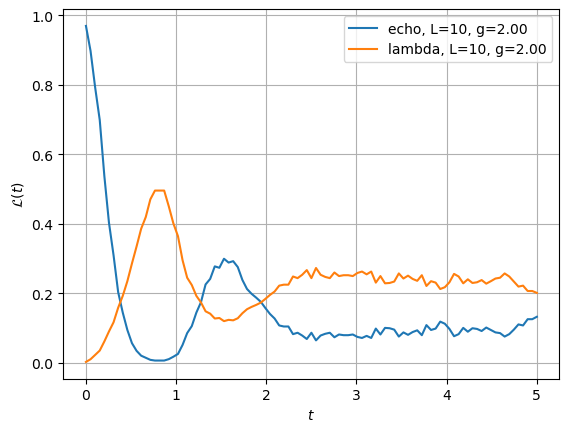

In [14]:
t, dt = 5, 0.05
Ls, gs = [10], [2]

measure_rates_over_grid_and_plot(Ls, gs, t, dt, shots=1000)

**Exercise 10**

In [15]:
t, dt = 5, 0.05
L, g = 10, 2

echos, λs = measure_rates(L, g, t, dt, shots=1000)

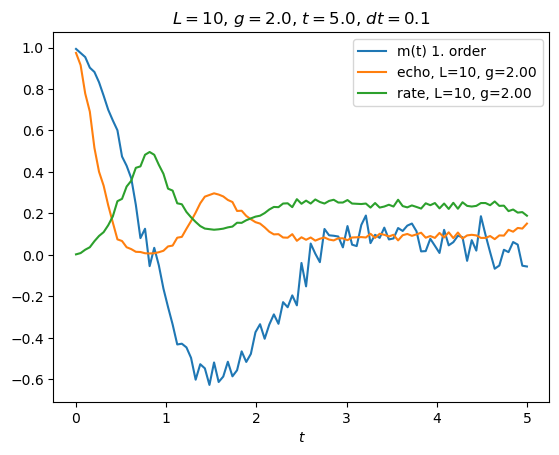

In [16]:
fig, ax = plt.subplots(1, 1)
ts = np.linspace(0, t, round(t//dt))
ax.plot(ts, ms_basic, '-', label='m(t) 1. order')
ax.plot(list(ts), echos, '-', label='echo, L=%d, g=%.2f'%(L, g))
ax.plot(ts, λs, '-', label='rate, L=%d, g=%.2f'%(L, g))
ax.grid()
ax.set_xlabel("$t$")
ax.legend()

ax.set_title('$L=%d$, $g=%.1f$, $t=%.1f$, $dt=%.1f$'%(L, g, t, dt)), ax.set_xlabel("$t$"), ax.legend(), ax.grid();

**Exercise 11**

In [17]:
import scipy
from qiskit.quantum_info import DensityMatrix, partial_trace

In [18]:
def get_rhol(state):
    rho = DensityMatrix(state)
    rho_l = partial_trace(state=rho, qargs=[5, 6, 7, 8, 9]) # trace out right hand side of system
    return rho_l.data

def vNentropy(rho):
    return -np.trace(rho@scipy.linalg.logm(rho))
    
    
def enyi2entropy(rho):
    return -np.log(np.trace(rho @ rho))

In [19]:
circ_basic = QuantumCircuit(L)

vNeumann =  []
renyi2 = []

t_ = 5
### Note, code takes very long to run, use results below!
# for _ in range(round(t_//dt)):
#     evolve_symmetric(circ_basic, g, dt)
#     rho_l = get_rhol(circ_basic)
#     vNeumann.append(vNentropy(rho_l))
#     renyi2.append(renyi2entropy(rho_l))
    
# vNeumann =  np.array(vNeumann)
# renyi2 = np.array(renyi2)
# np.save('SvNeumann.npy', vNeumann)
# np.save('Renyi2.npy', renyi2)

In [20]:
vNeumann = np.load('SvNeumann.npy')
renyi2 = np.load('Renyi2.npy')

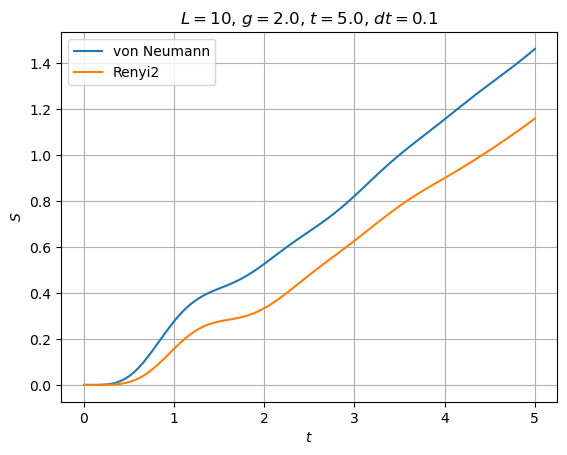

In [21]:
fig, ax = plt.subplots(1, 1)

ts = np.linspace(0, t_, round(t_//dt))

ax.plot(ts, np.real(vNeumann), '-', label='von Neumann')
ax.plot(ts, np.real(renyi2), '-', label='Renyi2')
ax.grid()
ax.set_xlabel("$t$")
ax.set_ylabel("$S$")
ax.legend()
ax.set_title('$L=%d$, $g=%.1f$, $t=%.1f$, $dt=%.1f$'%(L, g, t, dt))
plt.savefig('Entropy.pdf')

**Exercise 13**

In [22]:
from qiskit.quantum_info import random_unitary
from qiskit import BasicAer, execute, ClassicalRegister
import itertools

In [23]:
def hamming(s1, s2):
    """Calculate the Hamming distance between two bit strings"""
    # make sure they have the same length
    assert len(s1) == len(s2)
    # sums over boolean array
    return sum(c1 != c2 for c1, c2 in zip(s1, s2))

In [24]:
def compute(N_shots=2000, N_Us=200, N_steps=round(t_//dt)):
    
    circ_init = QuantumCircuit(L, L//2) ## L//2 classical bits to store results (5 in this case)
    
    X_list_t = []
    
    for _ in range(N_steps):

        evolve_symmetric(circ_init, g, dt)
        X_list = []

        for j in range(N_Us):

            # copy circuit here, so it doesn't get too long
            circ_basic = circ_init.copy()
            ### apply 1 random unitary
            for i in range(circ_basic.num_qubits):
                circ_basic.append(random_unitary(2), [i])


            circ_basic.measure([0, 1, 2, 3, 4], [0, 1, 2, 3, 4]) # measure the first 5 bits (subsystem A) 
            result = execute(circ_basic, BasicAer.get_backend('qasm_simulator'), shots=N_shots).result().get_counts()

            bitstring_list = list(result.keys())
            # [s1, s2, s3, ...]
            all_bitstring_combinations = list(itertools.product(bitstring_list, bitstring_list))
            # combination is [(s1, s2), (s1, s3), ....]
            X = 0
            for combination in all_bitstring_combinations:
                X += 2**(5)/(N_shots**2) * (-2)**(-hamming(*combination)) * result[combination[0]]* result[combination[1]]

            X_list.append(X)
        
        X_list_t.append(X_list)

    # convert to numpy array
    X_list_t = np.array(X_list_t)
    # extract second Renyi entropy
    S2 = -np.log(X_list_t.mean(axis=-1))
    
    return S2

In [25]:
## Note! Code takes very long to run, use results of previous run
# S2 = compute()
# np.save('S2.npy', S2)
S2 = np.load("S2.npy")

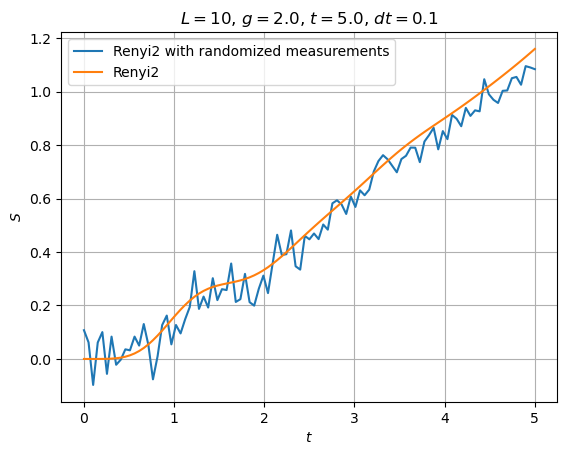

In [26]:
fig, ax = plt.subplots(1, 1)

ts = np.linspace(0, t_, round(t_//dt))

ax.plot(ts, np.real(S2), '-', label='Renyi2 with randomized measurements')
ax.plot(ts, np.real(renyi2), '-', label='Renyi2')
ax.grid()
ax.set_xlabel("$t$")
ax.set_ylabel("$S$")
ax.legend()
ax.set_title('$L=%d$, $g=%.1f$, $t=%.1f$, $dt=%.1f$'%(L, g, t, dt))
plt.savefig('Entropy_comparison.pdf')